### Keras implementation of Brain CNN

In [1]:
import tensorflow as tf
import numpy as np
import sklearn.metrics


from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
SNAPS = 8 ##Number of snaps over 4 seconds
STRIP_DEPTH = 8
# STRIP_WIDTH = IMG_WIDTH * SNAPS
# STRIP_HEIGHT = IMG_HEIGHT * STRIP_DEPTH
SLICE = 1
CLASSES = 2
conv1_filter = 4
conv2_filter = 8
conv3_filter = 16
conv4_filter = 32
conv5_filter = 4
conv6_filter = 4

In [3]:
experiment = '8snap3d'
path = '/work/aaung/datasets/' + experiment + '/'

_04847_img = np.load(path + '4847_' + experiment + '-image.npy')
_04799_img = np.load(path + '4799_' + experiment + '-image.npy')
_04820_img = np.load(path + '4820_' + experiment + '-image.npy')
_05675_img = np.load(path + '5675_' + experiment + '-image.npy')
_05680_img = np.load(path + '5680_' + experiment + '-image.npy')
_05710_img = np.load(path + '5710_' + experiment + '-image.npy')

_04847_lbl = np.load(path + '4847_' + experiment + '-label-onehot.npy')
_04799_lbl = np.load(path + '4799_' + experiment + '-label-onehot.npy')
_04820_lbl = np.load(path + '4820_' + experiment + '-label-onehot.npy')
_05675_lbl = np.load(path + '5675_' + experiment + '-label-onehot.npy')
_05680_lbl = np.load(path + '5680_' + experiment + '-label-onehot.npy')
_05710_lbl = np.load(path + '5710_' + experiment + '-label-onehot.npy')

### Leave on example out validation

In [4]:
# train_img = np.vstack((_04847_img[5:,], _04799_img[5:,], _04820_img[5:,], _05675_img[5:,], _05680_img[5:,]))
# train_lbl = np.vstack((_04847_lbl[5:,], _04799_lbl[5:,], _04820_lbl[5:,], _05675_lbl[5:,], _05680_lbl[5:,]))
# val_img = np.vstack((_04847_img[:5,], _04799_img[:5,], _04820_img[:5,], _05675_img[:5,], _05680_img[:5,]))
# val_lbl = np.vstack((_04847_lbl[:5,], _04799_lbl[:5,], _04820_lbl[:5,], _05675_lbl[:5,], _05680_lbl[:5,]))

# n = 10
# train_img = np.vstack((_04847_img[n:,], _04799_img[n:,], _04820_img[n:,], _05675_img[n:,], _05680_img[n:,], _05710_img[n:,]))
# train_lbl = np.vstack((_04847_lbl[n:,], _04799_lbl[n:,], _04820_lbl[n:,], _05675_lbl[n:,], _05680_lbl[n:,], _05710_lbl[n:,]))
# val_img = np.vstack((_04847_img[:n,], _04799_img[:n,], _04820_img[:n,], _05675_img[:n,], _05680_img[:n,], _05710_img[:n,]))
# val_lbl = np.vstack((_04847_lbl[:n,], _04799_lbl[:n,], _04820_lbl[:n,], _05675_lbl[:n,], _05680_lbl[:n,], _05710_lbl[:n,]))

# GOOD 0.7875
train_img = np.vstack((_05710_img, _04847_img, _04799_img, _05675_img, _05680_img))
train_lbl = np.vstack((_05710_lbl, _04847_lbl, _04799_lbl, _05675_lbl, _05680_lbl))
val_img =  _04820_img
val_lbl =  _04820_lbl 

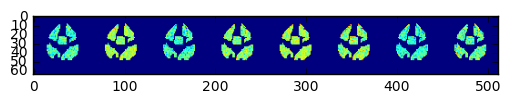

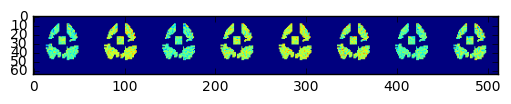

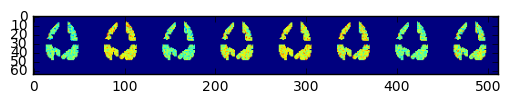

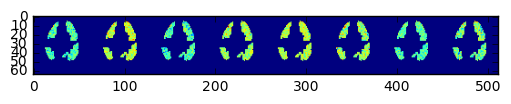

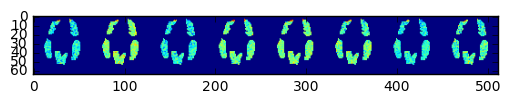

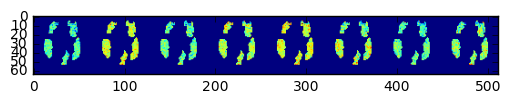

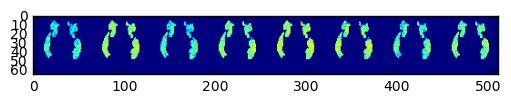

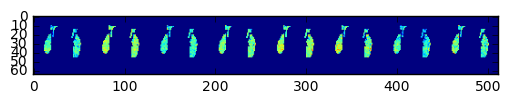

(400, 8, 64, 512)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(8):
    plt.show(plt.imshow(train_img[1,i,:,:]))
print train_img.shape

In [6]:
CHANNELS = train_img.shape[1]
STRIP_HEIGHT = train_img.shape[2]
STRIP_WIDTH = train_img.shape[3]

In [7]:
class EvaluateValidation(Callback):      
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nValidation loss: {}, acc: {}\n'.format(loss, acc))

In [8]:
np.random.seed(0)
# shuffle = np.random.permutation(database.shape[0])

# test = database[shuffle[0:100],:]
# val = database[shuffle[100:200],:]
# train = database[shuffle[200:],:]

xtrain = train_img
ytrain = train_lbl

xval = val_img
yval = val_lbl

### Model ###                                                                                                                               
model = Sequential()
mde = 0                                                                                                                                                                      
k_init = 'he_normal'
ridge = 0.0005

model.add(Convolution2D(conv1_filter, kernel_size=(3, 3), strides=(1, 1),
                        padding='same', data_format="channels_first", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer='zeros', input_shape=(CHANNELS, STRIP_HEIGHT, STRIP_WIDTH)))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(conv2_filter, kernel_size=(5, 5), strides=(1, 1),
                        padding='same', data_format="channels_first", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer='zeros'))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2), strides=(2, 2), padding='valid'))

model.add(Convolution2D(conv3_filter, kernel_size=(7, 7), strides=(1, 1),
                        padding='same', data_format="channels_first", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer='zeros'))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(conv4_filter, kernel_size=(9, 9), strides=(1, 1),
                        padding='same', data_format="channels_first", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer='zeros'))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2), strides=2, padding='valid'))

model.add(Flatten())
model.add(Dense(1024, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(512, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(CLASSES, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('softmax'))

Lr = 1e-4 
dcy = 1e-5                                                                                                                                                                                
m = 0.5
batch_sz = 25
epoch = 20
# sgd = SGD(lr=Lr, momentum=m, decay=dcy,  nesterov=True)
adam = Adam(lr=Lr, decay=dcy)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()
print('learning rate: %f, decay: %f' %(Lr, dcy))


from keras.backend import get_session
get_session().run(tf.global_variables_initializer())
a = model.fit(xtrain, ytrain, batch_size = batch_sz, epochs= epoch, verbose = 2,
              callbacks=[EvaluateValidation((xval, yval))])

loss_and_metrics = model.evaluate(xval, yval, batch_size=batch_sz)

print "Loss and accuracy: ", loss_and_metrics

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 64, 512)        292       
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 64, 512)        2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 64, 512)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 64, 512)        808       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 64, 512)        2048      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 64, 512)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 32, 512)        0         
__________

In [9]:
y_pred = model.predict(xval, batch_size=128)
y_pred = np.argmax(y_pred, axis=1)

In [10]:
y_true = np.argmax(yval, axis=1)

In [11]:
print "Precision", sklearn.metrics.precision_score(y_true, y_pred)
print "Recall", sklearn.metrics.recall_score(y_true, y_pred)
print "f1_score", sklearn.metrics.f1_score(y_true, y_pred)
print "confusion_matrix"
print sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[0, 1])
fpr, tpr, tresholds = sklearn.metrics.roc_curve(y_true, y_pred)
ras = sklearn.metrics.auc(fpr, tpr)
roauc_score = sklearn.metrics.roc_auc_score(y_true, y_pred)
print ras
print roauc_score

Precision 0.0
Recall 0.0
f1_score 0.0
confusion_matrix
[[40  0]
 [40  0]]
0.5
0.5


/home/aaung/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aaung/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
